# Authorship Verification

### Loading the needed libraries

In [1]:
import os
import re
from collections import Counter
import glob
from itertools import combinations, product

import lxml.etree
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_colwidth', 0)
import numpy as np
np.random.seed(18012023)
import seaborn as sb

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, precision_score, recall_score, precision_recall_curve
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.cluster import AgglomerativeClustering
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier

import scipy.spatial.distance as scidist

from bokeh.models import HoverTool, ColumnDataSource
from bokeh.plotting import figure, show, output_file, save
from bokeh.io import output_file, show, save, output_notebook
from bokeh.plotting import figure
from bokeh.models import Axis

import mpl_axes_aligner

### Loading data and metadata

In [2]:
def load_verses(filepath, rm_interpol=True):    
    tree = lxml.etree.parse(filepath)
    
    # leave out interpolations
    if rm_interpol:
        for interpolation in tree.xpath("//interpolation"):
            interpolation.getparent().remove(interpolation)
    
    verses = []
    
    # retrieve all verses and turn all proper nouns into the same string
    for line_node in tree.iterfind('//l'):
        verse = []
        
        lemma_tags = [l.text for l in line_node.iterfind('.//lemma')]
        pos_tags = [p.text for p in line_node.iterfind('.//pos')]
        
        for lemma, pos in zip(lemma_tags, pos_tags):
            for l, p in zip(lemma.split('+'), pos.split('+')):
                    if p == 'n(prop)':
                        verse.append(('n(prop)', 'n(prop)'))
                    else:
                        verse.append((l, p))
        
        verses.append(verse)
    
    return verses

In [3]:
meta_df = pd.read_excel('../data/metadata.xlsx')
meta_df = meta_df[meta_df['genre'] == 'Epiek']
meta_df = meta_df[meta_df['exclude'] != 'x']
meta_df.sample(10)

,id,title,author,provenance,date_range,genre,subgenre,exclude
85,heymelijchede_der_heymelijcheit,Heymelijchede der heymelijcheit,Jacob van Maerlant,cdrom-mnl,1374-1374,Epiek,Didactiek,NaN
216,spiegel_historiael__1_3_4_maerlant,Spiegel historiael (P1-P4),Jacob van Maerlant,cdrom-mnl,1300-1325,Epiek,Historiografie,NaN
11,bediedenisse_van_der_missen,Bediedenisse van der missen,NaN,cdrom-mnl,1340-1360,Epiek,Religie,NaN
105,lantsloot_van_der_haghedochte,Lantsloot van der Haghedochte,NaN,cdrom-mnl,1300-1350,Epiek,Arthur,NaN
126,madelgijs_fragm_g2,Madelgijs,NaN,cdrom-mnl,1340-1360,Epiek,Karel,NaN
46,der_ystorien_bloeme,Der ystorien bloeme,NaN,cdrom-mnl,1340-1360,Epiek,Historiografie,NaN
145,ogier_van_denemarken_fragm_br1,Ogier van Denemarken,NaN,cdrom-mnl,1300-1400,Epiek,Karel,NaN
99,korte_kroniek_van_brabant_korte_versie_1,Korte kroniek van Brabant (korte versie 1),Jan van Boendale,cdrom-mnl,1399-1410,Epiek,Historiografie,NaN
41,der_mannen_ende_vrouwen_heimelijcheit,Der mannen ende vrouwen heimelijcheit,NaN,cdrom-mnl,1351-1351,Epiek,Didactiek,NaN
154,ongeidentificeerd_fragment,Ongeïdentificeerd fragment,NaN,cdrom-mnl,1380-1400,Epiek,Didactiek,NaN


In [4]:
# transform all verses into their lemmatized versions

works = []
rm_interpol = True

pbar = tqdm(meta_df.groupby('title'), desc='description')
for title, group in pbar:
    pbar.set_description('{message: <{width}}'.format(message=title[:50], width=50))
    meta = list(group.sample(1)[['title', 'author', 'genre', 'subgenre']].values[0])
    words = []
    
    for id_ in sorted(group['id']):
        try:
            words.extend(load_verses(f'../data/xml/{id_}.xml', rm_interpol=rm_interpol))
        except OSError:
            print(f'- Could not load {id_}')
            continue
    
    works.append(meta + [words])

work_df = pd.DataFrame(works, columns=['title', 'author', 'genre', 'subgenre', 'text'])

Wrake van Ragisel                                 : 100%|█| 162/162 [00:09<00:00


In [5]:
def load_segher(filepath):    
    tree = lxml.etree.parse(filepath)
    verses = []
    for interpolation in tree.xpath("//interpolation"):
        for line_node in interpolation.iterfind('.//l'):
            verse = []

            lemma_tags = [l.text for l in line_node.iterfind('.//lemma')]
            pos_tags = [p.text for p in line_node.iterfind('.//pos')]

            for lemma, pos in zip(lemma_tags, pos_tags):
                for l, p in zip(lemma.split('+'), pos.split('+')):
                        if p == 'n(prop)':
                            verse.append(('n(prop)', 'n(prop)'))
                        else:
                            verse.append((l, p))
            verses.append(verse)    
    return verses

segher = load_segher('../data/xml/historie_van_troyen.xml')

work_df.loc[len(work_df)] = ['Trojeroman', 'Segher', 'Epiek', 'Ridder', segher]

### Segmentation of the texts into equal parts

In [6]:
# check how many verses each work entails (for instance Cassamus has 1890 verses)

# len(work_df[work_df['title'].str.contains('Elegast')]['text'].iloc[0])
len(work_df[work_df['title'].str.contains('Cassamus')]['text'].iloc[0])
# len(work_df[work_df['title'].str.contains('Saladijn')]['text'].iloc[0])

1890

In [7]:
# divide the texts into segments of equal length

def segment(work_df, rhyme_only=True, incl_lemma=True, incl_pos=False, segment_length = 2000, min_length=1364):        
    if not (incl_pos or incl_lemma):
        raise ValueError('incl_lemma OR incl_pos must be set to True')

    segments = []

    for _, row in tqdm(list(work_df.iterrows())):
        if rhyme_only:
            text = [verse[-1] for verse in row['text']]
        else:
            text = [item for sublist in row['text'] for item in sublist]
        
        if incl_lemma and incl_pos:
            text = ['@'.join(p) for p in text]
        elif incl_lemma:
            text = [p[0] for p in text]
        else:
            text = [p[1] for p in text]

        meta = [row['title'], row['author'], row['genre'], row['subgenre']]
        
        if row['title'] == 'Van Saladijn':
            text = text[::2] + text[1::2]
        
        if segment_length:
            if len(text) < segment_length:
                continue
            si, ei, idx = 0, segment_length, 1
            while ei < len(text):
                segments.append(meta + [idx, text[si:ei]])
                idx += 1
                si += segment_length
                ei += segment_length
        else:
            if len(text) >= min_length:
                segments.append(meta + [0, text])

    return pd.DataFrame(segments, columns=['title', 'author', 'genre', 'subgenre', 'segment-idx', 'text'])

segment_df = segment(work_df, rhyme_only=True, incl_pos=False, segment_length=1889)
segment_df.sample(5)

100%|████████████████████████████████████████| 163/163 [00:00<00:00, 821.53it/s]


,title,author,genre,subgenre,segment-idx,text
223,Segheliin van Jerusalem,Loy Latewaert,Epiek,Kruisvaart,3,"[zeggen, ontvangen, doen, lijf, wijf, goom, oom, gelijk, rijk, n(prop), mijn, jonkvrouw, trouw, n(prop), arend, groot, dood, zeer, tafer, vroed, spoed, heer, eer, ontvangen, jongeling, kroon, schoon, zijn, zegelijn, aan, zaan, wie, vrouw, lijf, wijf, gevallen, wel, christenheid, mede, zijn, dat, rijden, tijd, man, n(prop), te, eer, zegelijn, zijn, dragen, dag, geven, leven, n(prop), zijn, uitermate, zitten, avontuur, creatuur, zaan, n(prop), gij, du, gevoeg, slaan, drank, gemang, vermoorden, behoren, versmaden, bedenken, n(prop), ontberen, juweel, kasteel, daar, overwaar, zijn, dat, kasteel, juweel, kroon, troon, geweld, veld, toorn, verkiezen, uur, avontuur, zekerlijk, n(prop), best, vesten, degen, beliggen, hoop, lopen, zeer, heer, waar, ...]"
78,Floris ende Blancefloer,Diederic van Assenede,Epiek,Ridder,2,"[heten, zijn, n(prop), tellen, gezel, beraden, scheiden, voort, poort, rood, bieden, nieuw, uw, dank, bedwang, dolen, verstolen, zullen, ongeval, leed, gereed, geven, leven, spreken, zaak, vergeten, eten, schoonlaken, maken, slapen, knaap, zoeken, dunken, zien, liggen, haar, gewaar, al, ongeval, blijven, drijven, verwijzen, blazen, gaan, kamerling, n(prop), doen, plegen, niet, stad, pad, kasteel, deel, worden, verteren, vroeg, toen, lijden, rijden, dag, slag, vespertijd, wijd, diep, lopen, gaan, hangen, steken, zaak, willen, zullen, n(prop), n(prop), mede, doen, komen, vernemen, stond, vinden, komen, nemen, weer, neder, plegen, zien, gebaren, varen, land, hand, zien, plegen, ver, gaarne, voort, poort, gezel, stellen, goed, gemoed, gemak, ...]"
286,Spiegel historiael (P2),Philip Utenbroeke,Epiek,Historiografie,3,"[gaan, kuur, deur, kunnen, stond, niet, iet, dood, groot, vijand, hand, daarin, zin, barrevoet, goed, paard, waart, vier, schier, n(prop), doorn, geraakt, maken, huisje, n(prop), daar, naar, ave, geven, af, graf, werven, sterven, doen, zaan, uur, senator, zoeken, mogen, nader, zijn, dood, groot, bij, zij, nader, gewaar, zenden, hand, mare, zijn, geroon, doen, horen, kiezen, n(prop), gomen, 7, leven, dus, n(prop), groot, bloed, agnes, deze, arthritiek, tijdelijk, dag, klaag, komen, nemen, venijn, zijn, zaan, ontvangen, verstaan, n(prop), kunnen, grond, de, nie, kwaad, haten, iets, niet, aanschijn, zijn, jongeling, ding, zeer, oneer, stad, doen, komen, vernemen, staan, aanvangen, troosten, onverlossen, zijn, ...]"
233,Sinte Franciscus leven,Jacob van Maerlant,Epiek,Heiligenleven,4,"[knecht, echt, mede, beide, reinigheid, mede, brengen, kracht, ontvangen, verstaan, berechten, licht, zin, in, zonde, stond, schriftuur, duren, behoren, voort, dat, lezen, zin, in, zeer, heer, verhoren, voor, zin, minne, vragen, behagen, verstaan, ontvangen, schriftuur, uur, aldus, n(prop), lezen, zijn, gebed, mede, doen, sermoen, aan, dan, mijn, zijn, mede, waarheid, n(prop), houden, eenvoudigheid, behendigheid, nimmermeer, heer, mond, oorkonde, stad, mede, n(prop), lijden, waan, verstaan, klaar, daar, heer, zeer, lijden, n(prop), zuiverheid, mede, zijn, arend, vaart, n(prop), vroed, moed, ontbinden, vinden, licht, echt, keur, schriftuur, dragen, genoeg, leven, geven, binnen, zin, waar, klaar, geschieden, bezien, bedekken, trekken, mede, jegenwoordigheid, geven, beneven, ...]"
5,Alexanders geesten,Jacob van Maerlant,Epiek,Ridder,6,"[n(prop), open, n(prop), daarna, saremate, uitermate, land, wijgend, koningin, winnen, n(prop), n(prop), hand, bachtenrand, heten, gaan, moordenaar, schare, verslaan, jegen, n(prop), compantie, man, daaraan, ontvangen, waan, nacht, kracht, hun, bruin, zijn, n(prop), oorlog, oog, bij, n(prop), noordzijde, tijd, noordoostwinde, twint, land, tehand, aldaar, haar, daarnaar, aldaar, n(prop), zitten, gaan, ding, n(prop), n(prop), ontvangen, staan, waan, ontvangen, jaar, waar, n(prop), na, zee, mee, land, noemen, wijleneer, meer, na, n(prop), evangelist, weten, n(prop), n(prop), n(prop), na, n(prop), aldus, daa

In [8]:
len(segment_df[segment_df['title'].str.contains('Cassamus')]['text'].iloc[0])

1889

### Combinations of the segments

In [9]:
# select the foreground and the background works

calib_df = segment_df[segment_df['author'].isin({'Jacob van Maerlant', 'Lodewijk van Velthem', 'Jan van Boendale'})]
trg_df = segment_df[segment_df['title'].isin({'Limborch', 'Rose',
                                              'Roman van Cassamus (kort)',
                                              'Roman der Lorreinen II',
                                              'Van Saladijn'})]
                                              #'Borchgravinne van Vergi (1)', 'Roman van Caesar', 
                                              
calib_df = calib_df[calib_df['title'] != 'Torec']
calib_df = calib_df[calib_df['title'] != 'Merlijn']
#calib_df = calib_df[calib_df['title'] != 'Van den derden Eduwaert']
#calib_df = calib_df[calib_df['title'] != 'Boec vander wraken']
#calib_df = calib_df[calib_df['title'] != 'Heymelijchede der heymelijcheit']

In [10]:
calib_df[['author', 'title']].value_counts()

author                title                          
Jacob van Maerlant    Spiegel historiael (P1-P4)         46
                      Historie van Troyen                19
                      Rijmbijbel                         19
Lodewijk van Velthem  Merlijn-continuatie                13
Jan van Boendale      Der leken spieghel                 11
Lodewijk van Velthem  Spiegel historiael (P5)            10
Jacob van Maerlant    Der naturen bloeme                 9 
                      Alexanders geesten                 7 
                      Sinte Franciscus leven             5 
Jan van Boendale      Brabantsche yeesten (B1-5)         3 
Lodewijk van Velthem  Spiegel historiael (P4)            3 
Jan van Boendale      Boec vander wraken                 2 
                      Jans teesteye                      2 
Jacob van Maerlant    Heymelijchede der heymelijcheit    1 
Jan van Boendale      Van den derden Eduwaert            1 
Name: count, dtype: int64

In [11]:
# create combinations of all of the segments and identify whether they were written by the same author or not

combos = []
authors_titles = [g for g, _ in calib_df.groupby(['author', 'title'])]
for c1, c2 in combinations(authors_titles, 2):
    if c1[0] == c2[0]:
        combos.append((c1[1], c2[1], 'S'))
    else:
        combos.append((c1[1], c2[1], 'D'))

combos = pd.DataFrame(combos, columns=['title1', 'title2', 'authorship'])
print(combos['authorship'].value_counts())
combos.sample(5)

authorship
D    71
S    34
Name: count, dtype: int64


,title1,title2,authorship
19,Der naturen bloeme,Boec vander wraken,D
28,Heymelijchede der heymelijcheit,Rijmbijbel,S
13,Alexanders geesten,Spiegel historiael (P5),D
2,Alexanders geesten,Historie van Troyen,S
31,Heymelijchede der heymelijcheit,Boec vander wraken,D


In [12]:
# vectorize the texts

def identity(x):
    return x

def bigrams(text):
    for i in range(len(text)-1):
        if 'n(prop)' not in text[i:i+2]:
            yield '-'.join((sorted(text[i:i+2])))
            
def unigrams(text):
    for i in range(len(text)):
        if 'n(prop)' not in text[i]:
            yield text[i]

params = {'use_idf': True,
          'max_features': 10000,
          'analyzer': bigrams,
          'min_df': 2}

vectorizer = TfidfVectorizer(**params)
vectorizer.fit(list(calib_df['text']) + list(trg_df['text']))
X = vectorizer.transform(calib_df['text']).toarray()

### Calibrating the threshold

In [13]:
# calibrate the cosine distances between text pairs

calib_distances = []

for idx, row in combos.iterrows():
    AX = X[calib_df['title'] == row['title1']]
    BX = X[calib_df['title'] == row['title2']]
    
    for distance in scidist.cdist(AX, BX, metric='cosine').flatten():
        calib_distances.append((row['title1'], row['title2'], row['authorship'], distance))

calib_distances = pd.DataFrame(calib_distances, columns=['title1', 'title2', 'authorship', 'distance'])
calib_distances = calib_distances[~calib_distances['distance'].isna()]
calib_distances

,title1,title2,authorship,distance
0,Alexanders geesten,Der naturen bloeme,S,0.907483
1,Alexanders geesten,Der naturen bloeme,S,0.896217
2,Alexanders geesten,Der naturen bloeme,S,0.907025
3,Alexanders geesten,Der naturen bloeme,S,0.899510
4,Alexanders geesten,Der naturen bloeme,S,0.890350
...,...,...,...,...
9690,Spiegel historiael (P4),Spiegel historiael (P5),S,0.731830
9691,Spiegel historiael (P4),Spiegel historiael (P5),S,0.669199
9692,Spiegel historiael (P4),Spiegel historiael (P5),S,0.687975
9693,Spiegel historiael (P4),Spiegel historiael (P5),S,0.724076


max(f1)=0.0 @ theta=0.1347


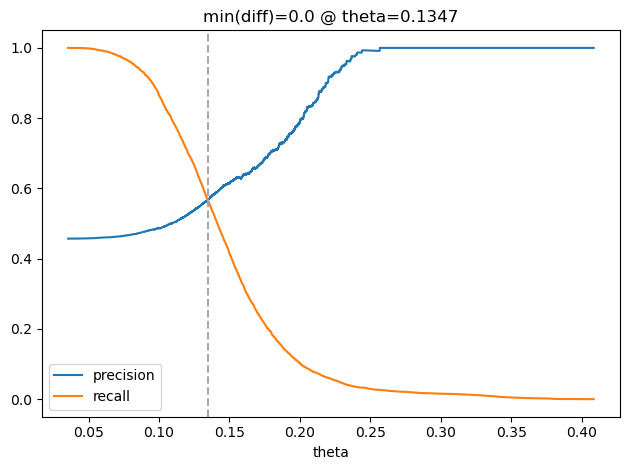

In [14]:
# calculate the optimal threshold to differentiate between same author and different author pairs

distances = 1 - np.array(calib_distances['distance'])
relevances = calib_distances['authorship']
precisions, recalls, thresholds = precision_recall_curve(relevances, distances, pos_label='S')
diffs = np.abs(precisions - recalls)
max_diff_idx = np.array(diffs).argmin()
max_diff = diffs[max_diff_idx]
max_diff_th = thresholds[max_diff_idx]
print(f'max(f1)={round(max_diff, 4)} @ theta={round(max_diff_th, 4)}')

plt.plot(thresholds, precisions[:-1], label='precision')
plt.plot(thresholds, recalls[:-1], label='recall')
plt.axvline(max_diff_th, ls='--', c='darkgrey')
plt.gca().set_xlabel('theta')
plt.gca().legend()
plt.title(f'min(diff)={round(max_diff, 4)} @ theta={round(max_diff_th, 4)}')
plt.tight_layout()

In [15]:
calib_thresh = 1 - max_diff_th
calib_thresh

0.865343982143404

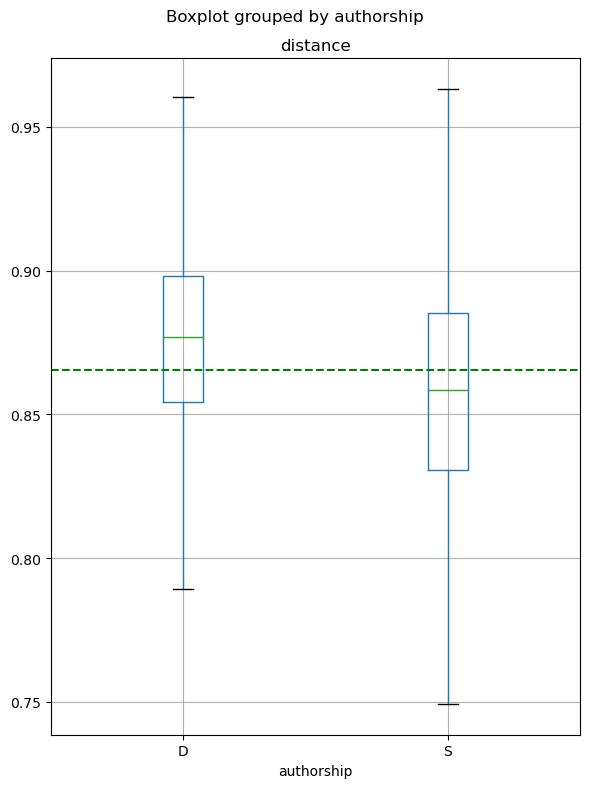

In [16]:
# plot the calibration

calib_distances.boxplot('distance', 'authorship', figsize=(6, 8), showfliers=False)
plt.axhline(calib_thresh, c='green', ls='--')
plt.tight_layout();

### Calculate distances in the foreground corpus and compare to the calibration

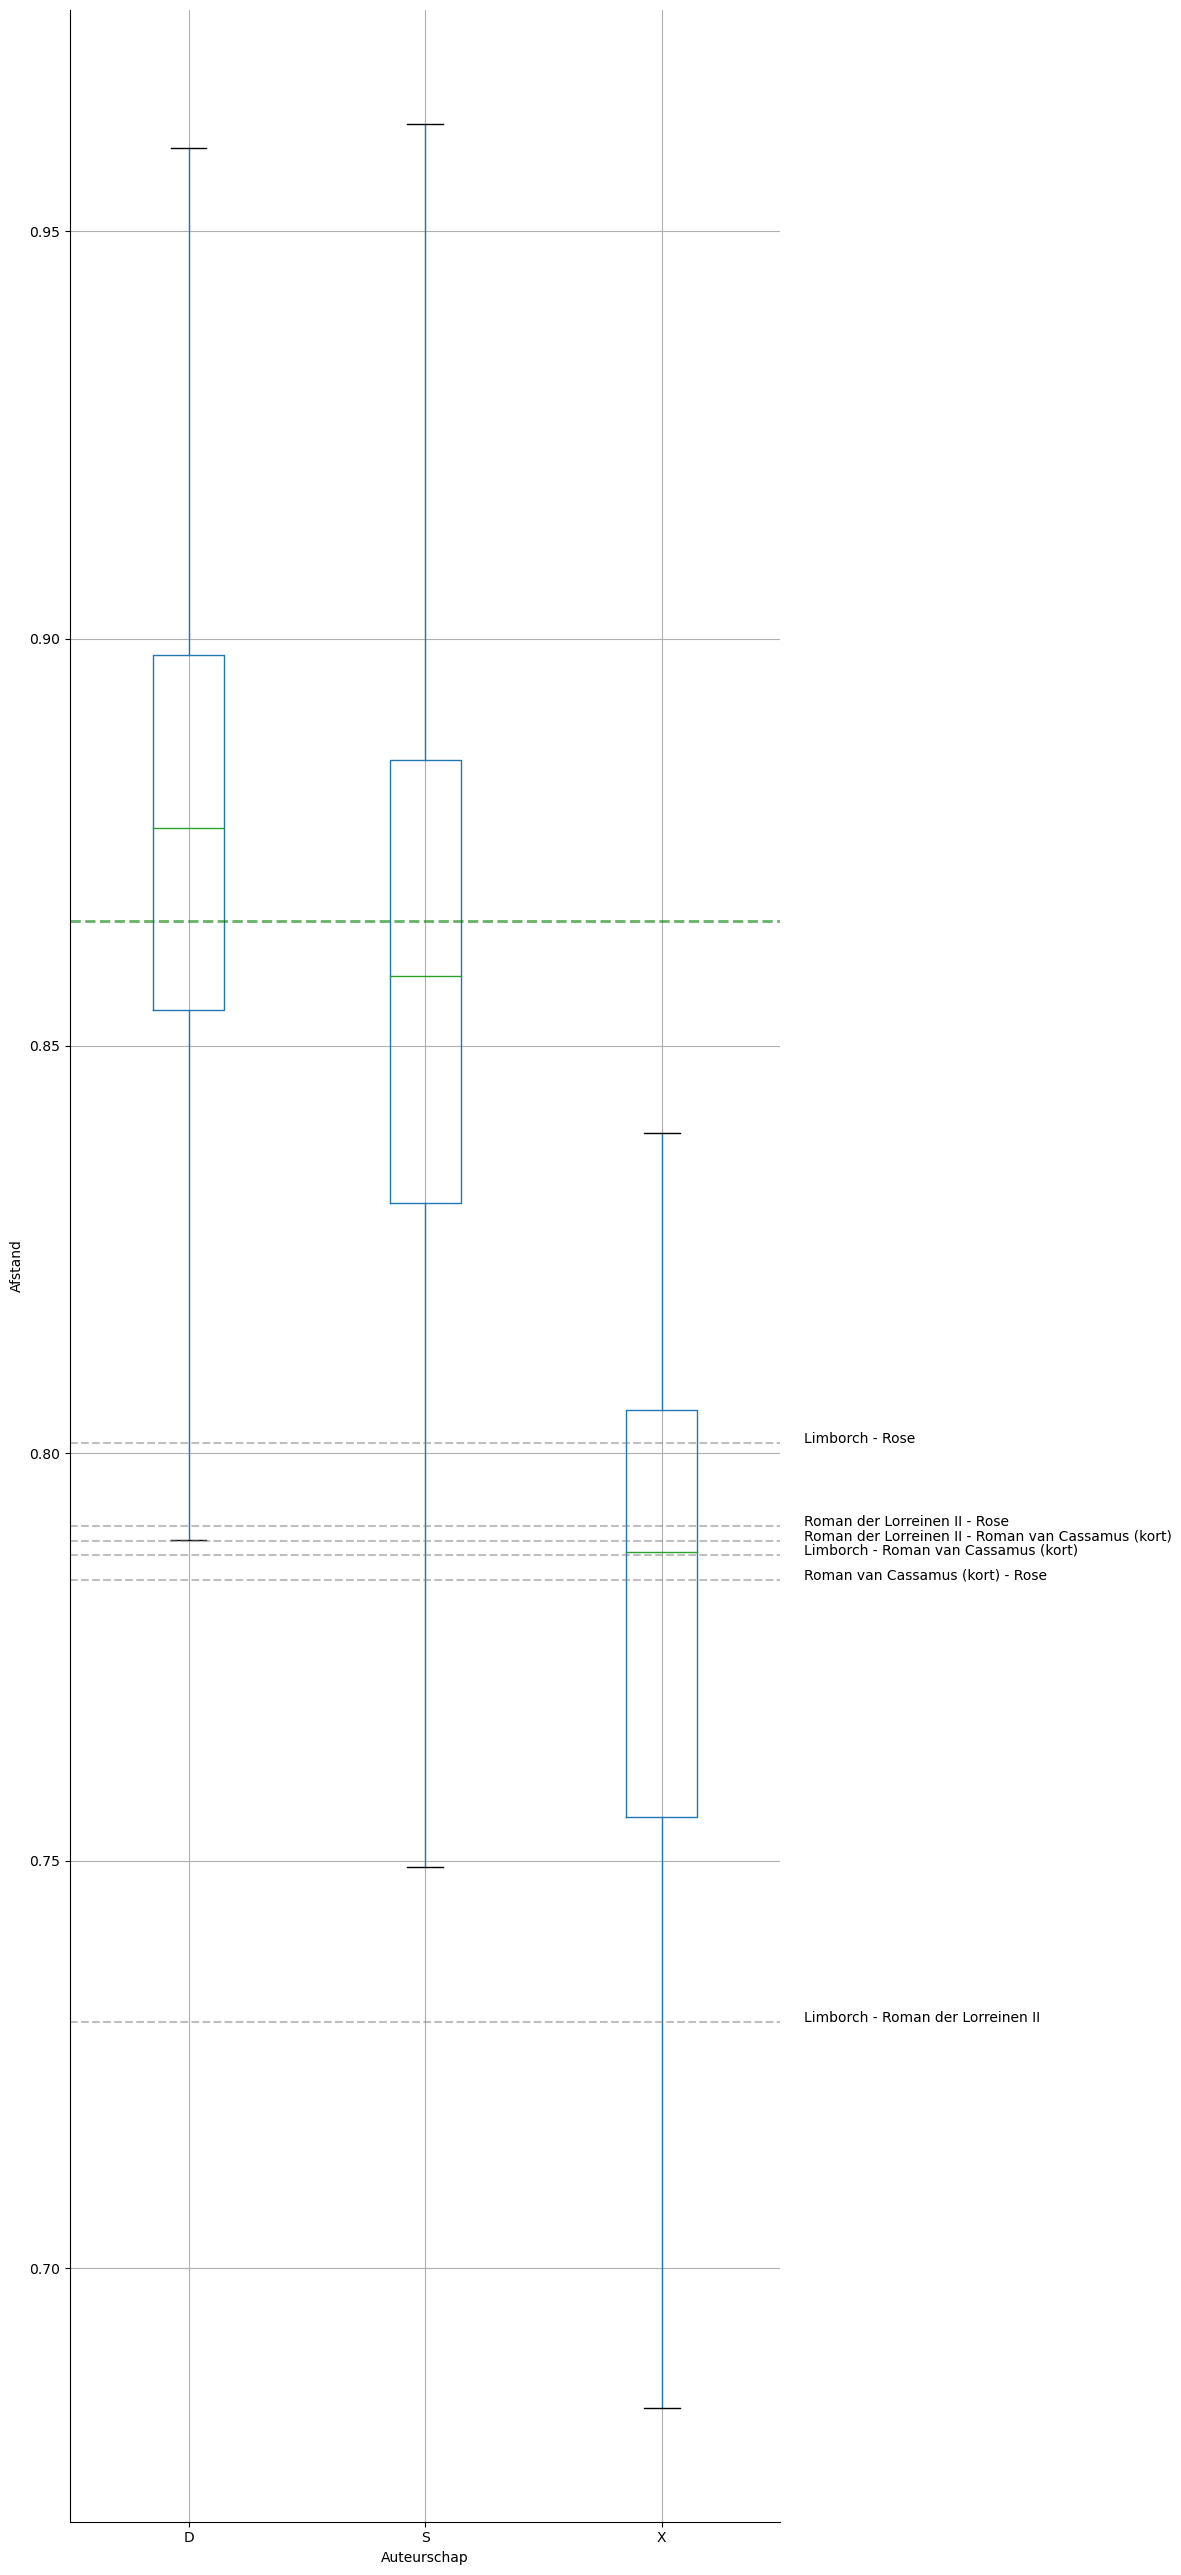

In [17]:
# plot the distances of the foreground corpus on the calibration plot

trg_df = segment_df[segment_df['title'].isin({'Limborch', 'Rose', 'Roman van Cassamus (kort)',
                                              'Roman der Lorreinen II'})]
trg_X = vectorizer.transform(trg_df['text']).toarray()

combos = pd.DataFrame(combinations(trg_df['title'].unique(), 2), columns=['title1', 'title2'])
combos['authorship'] = 'X'

trg_distances = []

for idx, row in combos.iterrows():
    AX = trg_X[trg_df['title'] == row['title1']]
    BX = trg_X[trg_df['title'] == row['title2']]
    
    for distance in scidist.cdist(AX, BX, metric='cosine').flatten():
        trg_distances.append((row['title1'], row['title2'], row['authorship'], distance))

trg_distances = pd.DataFrame(trg_distances, columns=['title1', 'title2', 'authorship', 'distance'])
distances = pd.concat([calib_distances, trg_distances])

distances.boxplot('distance', 'authorship', figsize=(12, 26), showfliers=False)
sb.despine()
plt.axhline(calib_thresh, c='green', linewidth=2, ls='--', alpha=.6)

for grouper, group in distances.groupby('authorship'):
    if grouper == 'X':
        for m, d in group.groupby(['title1', 'title2'])['distance']:
            plt.gca().axhline(d.mean(), c='grey', ls='--', alpha=.5)
            plt.annotate(' - '.join(m), xy=[plt.gca().get_xlim()[1]+0.1, d.mean()],
                         annotation_clip=False)
            
plt.title('')
plt.xlabel('Auteurschap')
plt.ylabel('Afstand')
plt.suptitle('')

plt.tight_layout();

### Network

In [18]:
# dividing the texts into equal segments again

segment_df = segment(work_df, rhyme_only=True, incl_pos=False, segment_length=1017)
segment_df.sample(5)

100%|███████████████████████████████████████| 163/163 [00:00<00:00, 1629.82it/s]


,title,author,genre,subgenre,segment-idx,text
526,Spiegel historiael (P1-P4),Jacob van Maerlant,Epiek,Historiografie,55,"[voort, present, tent, bidden, stad, ave, geven, heiligedom, vroom, dool, stoel, poort, voorts, hand, land, de, schat, n(prop), wijs, kerk, klerk, zenden, n(prop), klootheid, willen, daad, raad, worden, openbaren, lijf, vijf, n(prop), recht, stad, mede, tijd, zijde, n(prop), lief, n(prop), recht, zijn, deze, begraven, have, senne, n(prop), hand, land, mede, stad, n(prop), alleen, leven, blijven, heer, keren, doen, koen, groot, dood, zoon, gene, oud, zullen, keizerijk, mogendlijk, dood, groot, n(prop), ontvangen, acht, macht, eer, heer, verstaan, aangaan, n(prop), ontvangen, leven, geven, oord, woord, beschrijven, leven, n(prop), zijn, en, bekennen, voorwaar, naar, stond, vinden, openbaar, zijn, vinden, altehand, dragen, zien, jaar, ...]"
35,Borchgravinne van Vergi (1),NaN,Epiek,Ridder,1,"[zijn, tijd, staan, leed, zeer, oneer, alleen, rein, verstaan, misdoen, kond, mond, geheel, bevelen, woord, ongebaren, lieden, bieden, kennen, winnen, al, zullen, weten, vergeten, brengen, ding, dracht, behagen, vijand, schande, weten, gemeed, stad, verraden, scheiden, veide, misval, zullen, geschieden, lieden, n(prop), vrij, koen, doen, tijd, strijd, bij, vrij, hij, vernemen, zeer, eer, naam, bekwaam, zin, minne, vermogen, zoeken, minnen, kennen, laten, missen, dat, stad, plegen, dag, gaan, ding, beide, schalkheid, vermanen, gaan, burggravin, binnen, altoos, loos, weer, sedert, twee, wee, doen, goed, minnen, kind, liggen, dag, n(prop), zijn, alleen, klein, staan, gaan, zijn, gras, minnen, kennen, honderdje, zijn, zijn, zij, ...]"
632,Theophilus,NaN,Epiek,Heiligenleven,1,"[zenden, en, beginnen, bekennen, kunnen, gunnen, goed, moeder, maagd, bejagen, beschrijven, blijven, beduiden, lieden, zijn, lezen, openbaar, zijn, lachteren, achtereen, onderwinden, binden, vrouw, betrouwen, ijdelheid, mede, zaak, gemak, zonde, onderwinden, lof, of, achterstal, wel, zeggen, waarheid, genoot, groot, staan, kwaad, plegen, bezien, plegen, jegen, zijn, venijn, begrijpen, niphen, maken, smaken, ongeraaktheid, mede, doen, daartoe, koningin, begin, volkomen, vroom, rijk, ootmoediglijk, trouw, vrouw, genadig, gerard, groot, nood, gemeen, alleen, goedertieren, onduur, vader, algader, rijk, gelijk, winnen, kennen, werk, kerk, god, gebod, gebieden, groot, ding, brengen, lijf, drijven, geraakt, volmaakt, weten, vergeten, twint, kind, zoeken, dunken, binnen, bekennen, niet, zien, togen, oog, ...]"
498,Spiegel historiael (P1-P4),Jacob van Maerlant,Epiek,Historiografie,27,"[staan, zaan, n(prop), dat, heer, verkeren, verdrijven, blijven, aldus, n(prop), schriftuur, keur, zoon, gene, raad, aflaat, weer, neder, voet, moeten, tehand, band, vlieden, zien, hand, band, knecht, echt, gereed, kleed, getind, ontbinden, zijn, n(prop), kwijt, vlijt, vermaledijen, duivel, erre, ver, zaan, vangen, wezen, deze, achter, lachter, waar, varen, bede, zerigheid, genade, laden, tijd, zijn, n(prop), de, mede, stad, binden, stond, binden, hand, drievuldigheid, stad, zaan, vangen, niet, heten, stond, binden, zaan, verstaan, heer, zeer, pijnen, dijn, wezen, deze, manier, visieren, toe, toen, leren, heer, kwaad, staan, gaan, zaan, n(prop), de, keren, leer, zijn, n(prop), wel, fel, beschermen, gehermen, ik, du, ...]"
658,Walewein (Penninc),Penninc,Epiek,Arthur,7,"[weten, knecht, gerecht, ontpluiken, noot, al, vallen, bedwingen, ring, geer, heer, gaan, doen, vroom, komen, zien, niet, verwerken, brengen, trouw, vrouw, keren, leren, stad, genade, bevreden, lid, moeten, vroed, verdriet, iet, wederkeren, eer, doen, gaan, heer, keer, dat, n(prop), zijn, in, zwaard, vaart, zitten, eten, haastigheid, stad, laten, raden, ries, dat, het, vest, gaan, zaan, onbedacht, nacht, zoeken, roeken, mond, zonde, onbederven, sterven, gaan, zaan, blijven, knijf, vaart, zwaard, zijde, blij, mogen, gerecht, dringen, ring, af, cave, geweld, genende, schrode, verbloden, houden, mild, vaart, waarts, binnen, 

In [19]:
# creating a scatterplot which visualizes similarities between segments

def scatterplot(X, df, label_column=None, color_column=None):
    if color_column:
        ints = [int(i) for i in LabelEncoder().fit_transform([str(i) for i in df[color_column]])]
        colors = sb.color_palette('husl', n_colors=len(set(ints)))
    else:
        ints = AgglomerativeClustering(n_clusters=8).fit_predict(X)
        colors = sb.color_palette('husl', n_colors=8)
    
    colors = [tuple([int(c * 256) for c in color]) for color in colors]
    
    meta_fields = ['title', 'genre', 'subgenre']
    d = {c:list(df[c]) for c in meta_fields}
    d['color'] = ['#%02x%02x%02x' % colors[i] for i in ints]
    d['x'] = X[:, 0]
    d['y'] = X[:, 1]
    source = ColumnDataSource(data=d)

    TOOLS="pan,wheel_zoom,reset,hover,box_select,save"

    p = figure(title='Embeddings',
               tools=TOOLS,
               width=1000,
               height=800,
               outline_line_color="white")

    p.circle(x='x', y='y', color='color',
             source=source, size=8,
             fill_alpha=0.9, line_color=None)
    
    if label_column:
        for label, x, y in zip(df[label_column], d['x'], d['y']):
            if isinstance(label, str):
                p.text(x, y, text=[label], text_align="center", text_font_size="5pt")

    hover = p.select(dict(type=HoverTool))
    hover.tooltips = [(c, '@'+c) for c in meta_fields]
    
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None
    p.axis.axis_line_color = None
    p.axis.major_label_text_font_size = '0pt'

    # Turn off tick marks
    p.axis.major_tick_line_color = None
    p.axis[0].ticker.num_minor_ticks = 0
    p.axis[1].ticker.num_minor_ticks = 0
    show(p)

sub_df = segment_df[segment_df['subgenre'].isin({'Arthur', 'Karel', 'Ridder', 'Dier'}) | \
                    (segment_df['title'].isin(['Rose']))]
sub_df = sub_df[~sub_df['title'].isin({'Vlaamse Rose', 'Arturs doet', 'Merlijn-continuatie', 'Queeste van den Grale', 'Lancelot'})]

params = {'use_idf': True,
          'max_features': 500,
          'analyzer': bigrams,
          'min_df': 2}

vectorizer = TfidfVectorizer(**params)
BOW = vectorizer.fit_transform(sub_df['text']).toarray()
pca = PCA(n_components=15)
X = pca.fit_transform(BOW)
tsne = TSNE(n_components=2)
X = tsne.fit_transform(X)

scatterplot(X, sub_df, label_column='title', color_column='title')

In [20]:
# create a plot based on a subselection of works with the most telling features

sub_df = segment_df[segment_df['title'].isin({'Limborch', 'Rose', 'Roman van Cassamus (kort)',
                                              'Borchgravinne van Vergi (1)',
                                              'Roman der Lorreinen II',
                                              'Alexanders geesten',
                                              'Historie van Troyen',
                                              'Roman van Caesar',
                                              'Grimbergse oorlog', 'Grimbergse oorlog (cont)',
                                              'Rijmkroniek van Woeringen',
                                             })]
vectorizer = TfidfVectorizer(**params)
BOW = vectorizer.fit_transform(sub_df['text']).toarray()
BOW = StandardScaler().fit_transform(BOW)

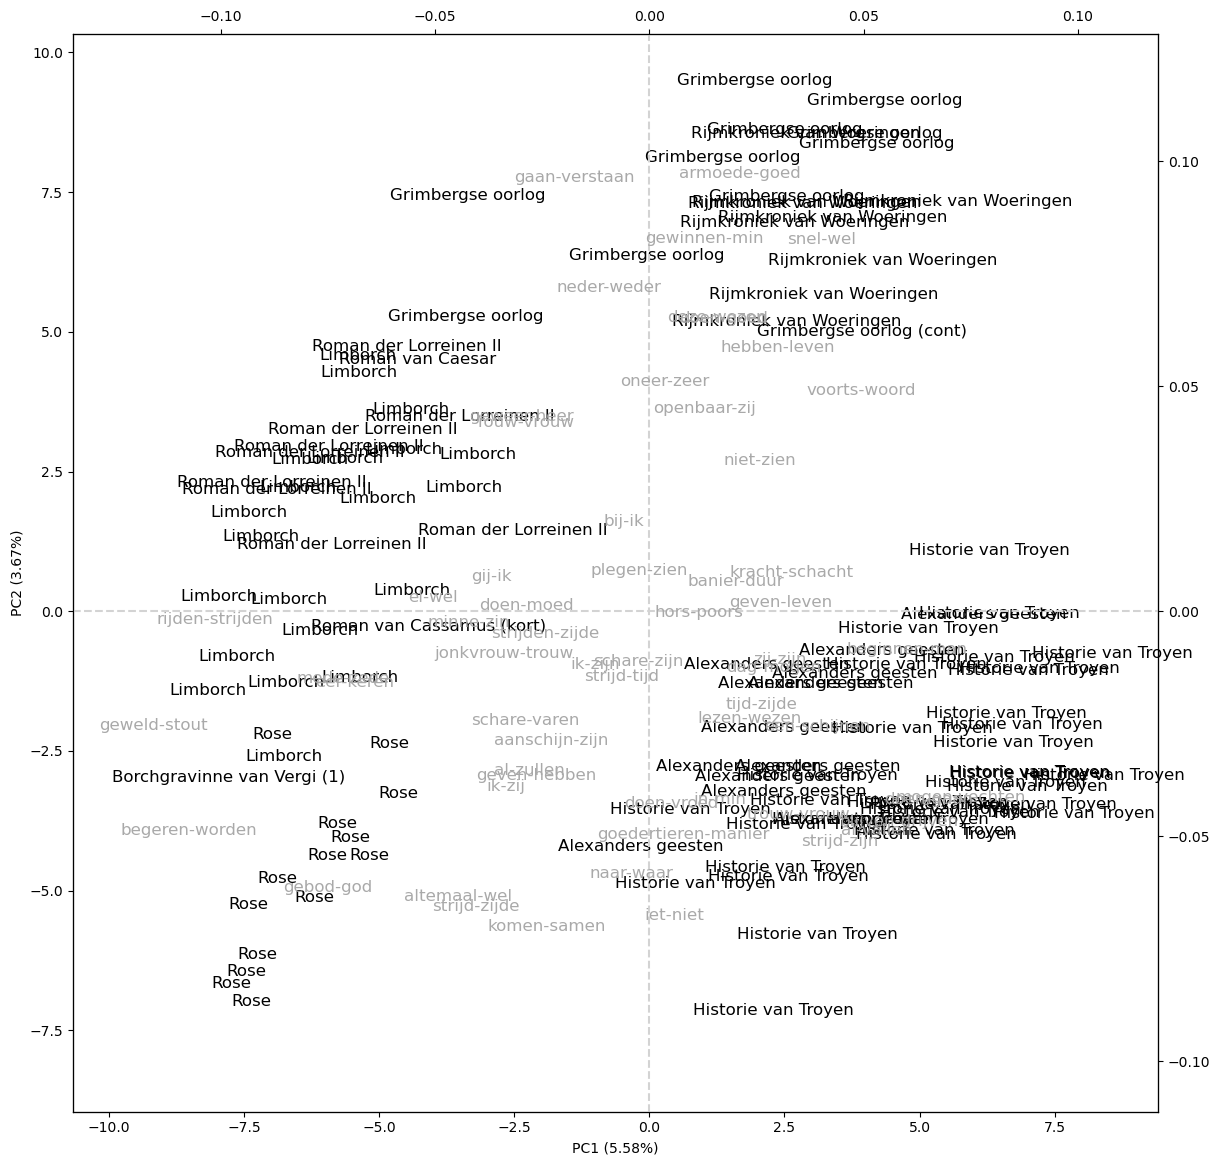

In [21]:
def plot_pca(document_proj, loadings, var_exp, labels):
    # first the texts:
    fig, text_ax = plt.subplots(figsize=(14, 14))
    x1, x2 = documents_proj[:, 0], documents_proj[:, 1]
    text_ax.scatter(x1, x2, facecolors='none')
    for p1, p2, label in zip(x1, x2, labels):
        text_ax.text(p1, p2, label, ha='center', va='center', fontsize=12)

    # add variance information to the axis labels:
    text_ax.set_xlabel(f'PC1 ({var_exp[0] * 100:.2f}%)')
    text_ax.set_ylabel(f'PC2 ({var_exp[1] * 100:.2f}%)')
    
    # now the loadings:
    loadings_ax = text_ax.twinx().twiny()
    l1, l2 = loadings[:, 0], loadings[:, 1]
    lc = l1 * l2
    m = 60
    top_idxs = lc.argsort()[::-1][:m]
    
    loadings_ax.scatter(l1[top_idxs], l2[top_idxs], facecolors='none');
    for x, y, loading in zip(l1, l2, np.array(vectorizer.get_feature_names_out())[top_idxs]):
        loadings_ax.text(x, y, loading, ha='center', va='center',
                         color='darkgrey', fontsize=12)

    mpl_axes_aligner.align.yaxes(text_ax, 0, loadings_ax, 0)
    mpl_axes_aligner.align.xaxes(text_ax, 0, loadings_ax, 0)
    
    # add lines through origins:
    plt.axvline(0, ls='dashed', c='lightgrey', zorder=0)
    plt.axhline(0, ls='dashed', c='lightgrey', zorder=0);

# fit the pca:
pca = PCA(n_components=2)
documents_proj = pca.fit_transform(BOW)
loadings = pca.components_.transpose()
var_exp = pca.explained_variance_ratio_

plot_pca(documents_proj, loadings, var_exp, sub_df['title'])

### Identifying nearest neighbours (verification)

In [22]:
# vectorizing

params = {'use_idf': True,
          'max_features': 10000,
          'analyzer': bigrams,
          'min_df': 2}

vectorizer = TfidfVectorizer(**params)
epics = segment_df[segment_df['genre'] == 'Epiek'].copy().reindex()
vectorizer.fit(epics['text'])
segment_X = vectorizer.transform(epics['text']).toarray()
segment_X.shape

(669, 10000)

In [23]:
# searching for the "nearest neighbours"

num_iter = 250
total_features = len(vectorizer.get_feature_names_out())
num_rnd_features = int(total_features * .5)
n_top_neighbors = 5

target_titles = ['Roman van Caesar', 'Limborch', 'Borchgravinne van Vergi (1)',
                 'Rose', 'Roman van Cassamus (kort)', 'Roman der Lorreinen II']

results = []

for target_title in target_titles:
    targets = epics[epics['title'] == target_title]
    candidates = epics[epics['title'] != target_title]
    neighbors = Counter()
    for trg_idx in tqdm(list(targets.index), desc=target_title):
        for i in range(num_iter):
            feats = np.random.choice(total_features, num_rnd_features, replace=False)
            ax = segment_X[trg_idx, feats]
            sampled = candidates.groupby('title').sample(1)
            xx = segment_X[sampled.index][:, feats]
            distances = scidist.cdist([ax], xx, metric='cosine').flatten()
            idxs = distances.argsort()[:1]
            neighbors.update(sampled.iloc[idxs]['title'])
    top_neighbors = neighbors.most_common(n_top_neighbors)
    summed = sum(neighbors.values())
    top_neighbors = [f'{k} ({(v / summed) * 100:.2f}%)' for k, v in top_neighbors]
    
    results.append([target_title] + top_neighbors)
    
results = pd.DataFrame(results, columns=['Target']+[f'Rank {i + 1}' for i in range(n_top_neighbors)])
results

Roman der Lorreinen II: 100%|█████████████████████| 9/9 [00:06<00:00,  1.48it/s]


,Target,Rank 1,Rank 2,Rank 3,Rank 4,Rank 5
0,Roman van Caesar,Roman der Lorreinen II (81.20%),Limborch (8.40%),Borchgravinne van Vergi (1) (4.80%),Perchevael (1.20%),Merlijn-continuatie (1.20%)
1,Limborch,Roman der Lorreinen II (29.94%),Borchgravinne van Vergi (1) (26.59%),Roman van Caesar (25.20%),Perchevael (2.61%),Roman van Cassamus (kort) (1.83%)
2,Borchgravinne van Vergi (1),Roman der Lorreinen II (42.00%),Limborch (22.40%),Rose (9.60%),Roman van Caesar (7.20%),Perchevael (4.80%)
3,Rose,Borchgravinne van Vergi (1) (43.14%),Roman van Caesar (17.43%),Roman der Lorreinen II (12.20%),Dietsche doctrinale (7.26%),Limborch (4.34%)
4,Roman van Cassamus (kort),Borchgravinne van Vergi (1) (39.60%),Roman der Lorreinen II (28.80%),Limborch (12.00%),Enaamse Codex (3.20%),Walewein ende Keye (2.00%)
5,Roman der Lorreinen II,Roman van Caesar (78.13%),Borchgravinne van Vergi (1) (9.16%),Limborch (6.44%),Grimbergse oorlog (1.07%),Arturs doet (0.93%)


### Feature analysis

#### Presumed oeuvre vs. rest

In [24]:
# investigating the important features in the presumed oeuvre

BOW = pd.DataFrame(segment_X, columns=vectorizer.get_feature_names_out())
BOW.index = epics['title'].isin(['Roman van Caesar', 'Limborch', 'Borchgravinne van Vergi (1)',
                 'Rose', 'Roman van Cassamus (kort)', 'Roman der Lorreinen II'])

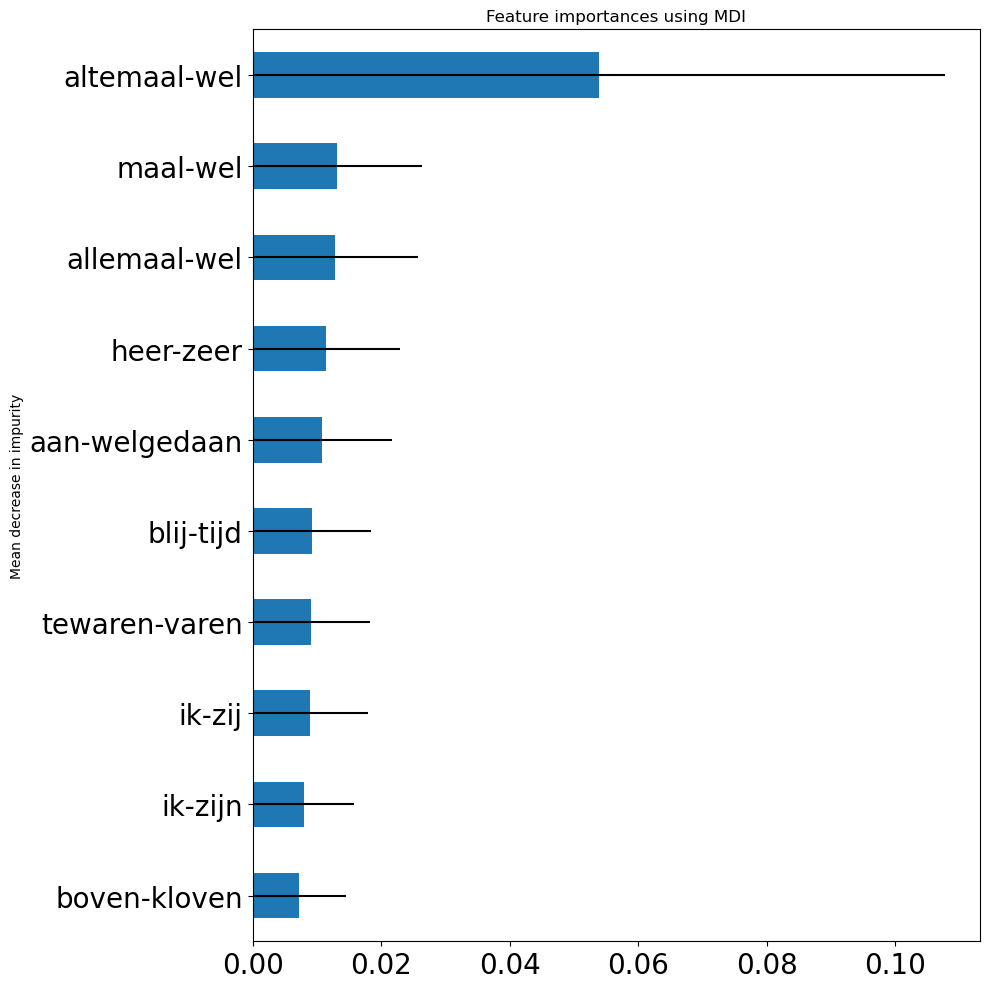

In [25]:
classes = BOW.index

feature_names = vectorizer.get_feature_names_out()
forest = RandomForestClassifier(random_state=0)
forest.fit(BOW, classes)

importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

cutoff = 10
forest_importances = pd.Series(importances, index=feature_names)
std = pd.Series(std, index=feature_names)
forest_importances = forest_importances.sort_values(ascending=False).head(cutoff)[::-1]
std = forest_importances.loc[forest_importances.index].head(cutoff)[::-1]

fig, ax = plt.subplots(figsize=(10, 10))
forest_importances.plot.barh(xerr=std, ax=ax, fontsize=20)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

/Users/carolinevandyck/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


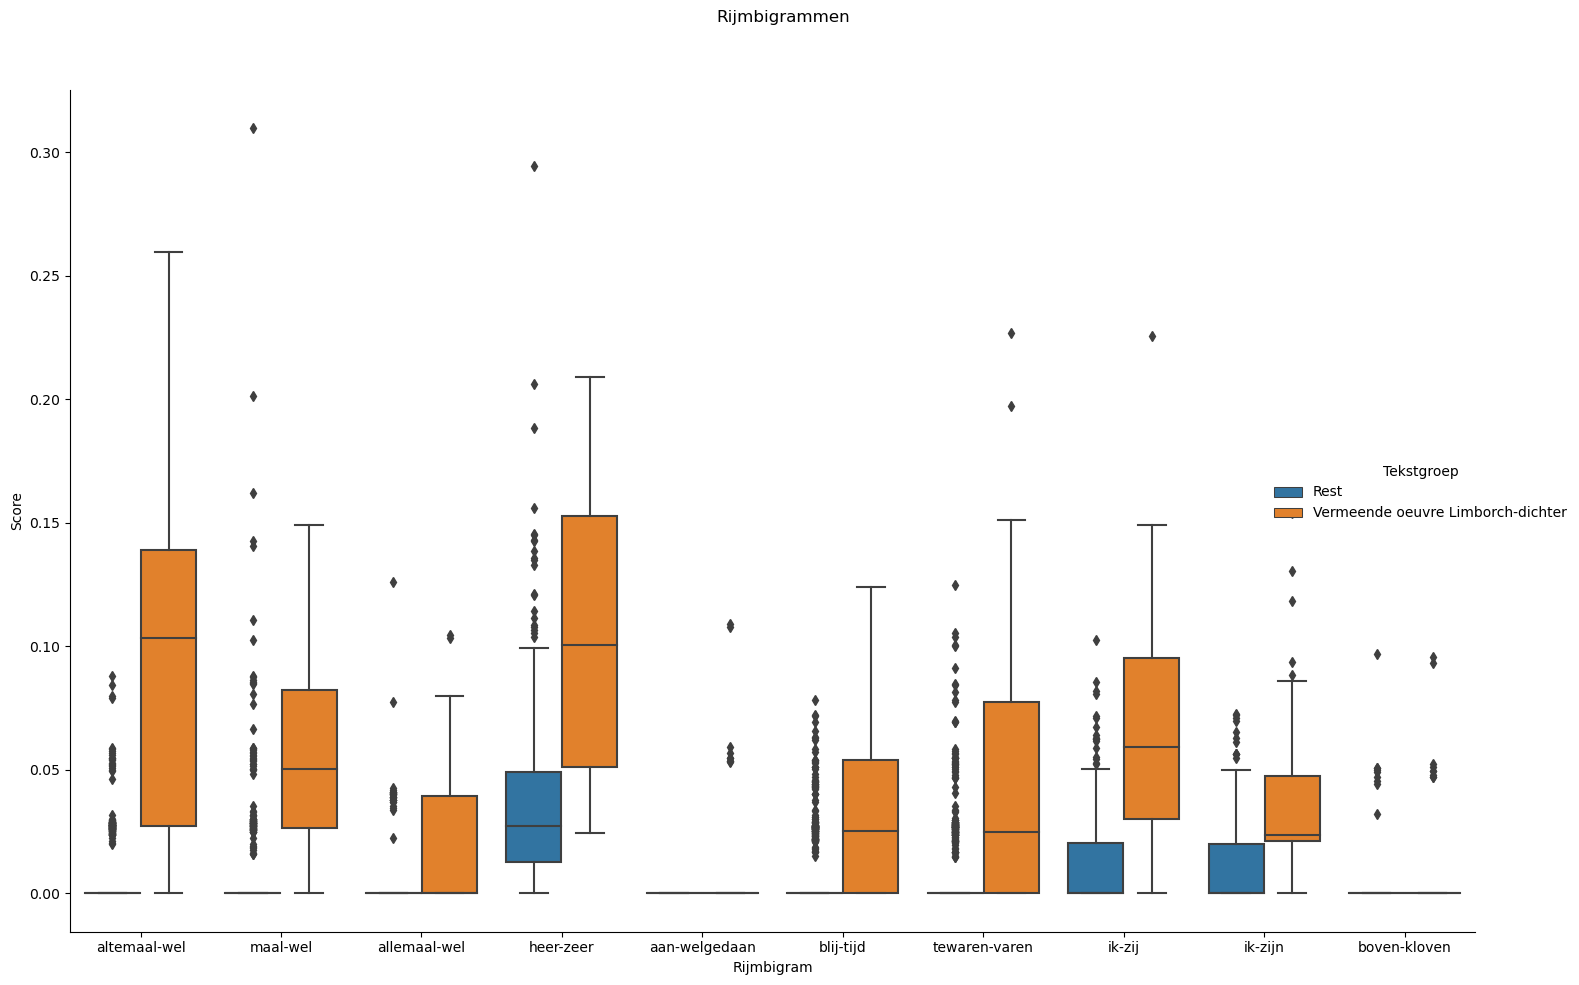

In [26]:
BOW = BOW[forest_importances.index[::-1]]
BOW.index = classes
bow = pd.melt(BOW, value_vars=BOW.columns, ignore_index=False, var_name='Rijmbigram', value_name='Score')
bow = bow.reset_index()
bow['authorship'] = bow['title']
plot = sb.catplot(x="Rijmbigram", hue="authorship", y="Score", data=bow, kind='box', height=10, aspect=1.5);

plot.fig.suptitle('Rijmbigrammen')
legend = plot._legend
legend.set_title('Tekstgroep')
legend.texts[0].set_text('Rest')
legend.texts[1].set_text('Vermeende oeuvre Limborch-dichter')
plt.subplots_adjust(top=0.9)

plt.show()

#### Rose vs. presumed oeuvre

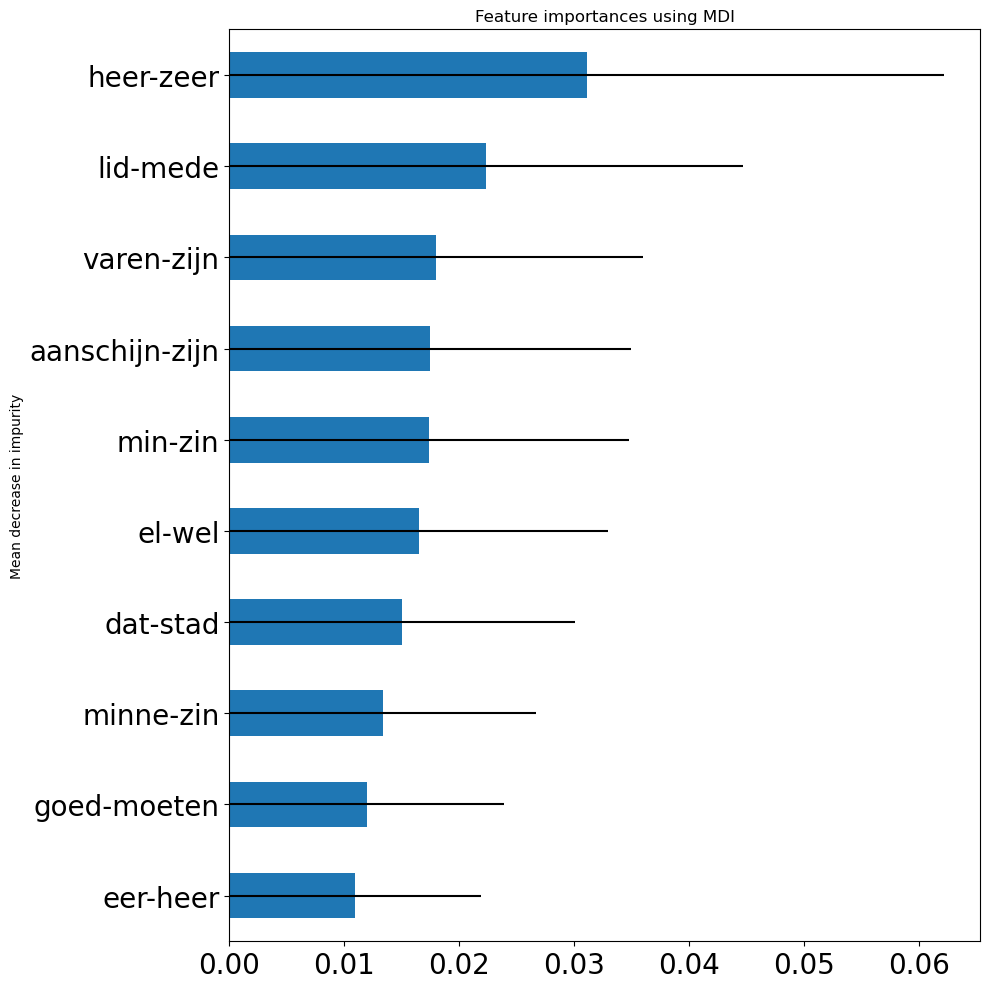

In [27]:
# repeating the experiment for the Rose in contrast to the other works in the presumed oeuvre


epics = epics[epics['title'].isin(['Roman van Caesar', 'Limborch', 'Borchgravinne van Vergi (1)',
                 'Rose', 'Roman van Cassamus (kort)', 'Roman der Lorreinen II'])]
segment_X = vectorizer.transform(epics['text']).toarray()

BOW = pd.DataFrame(segment_X, columns=vectorizer.get_feature_names_out())
BOW.index = epics['title'] == 'Rose'

classes = BOW.index

feature_names = vectorizer.get_feature_names_out()
forest = RandomForestClassifier(random_state=0)
forest.fit(BOW, classes)

importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

cutoff = 10
forest_importances = pd.Series(importances, index=feature_names)
std = pd.Series(std, index=feature_names)
forest_importances = forest_importances.sort_values(ascending=False).head(cutoff)[::-1]
std = forest_importances.loc[forest_importances.index].head(cutoff)[::-1]

fig, ax = plt.subplots(figsize=(10, 10))
forest_importances.plot.barh(xerr=std, ax=ax, fontsize=20)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

/Users/carolinevandyck/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


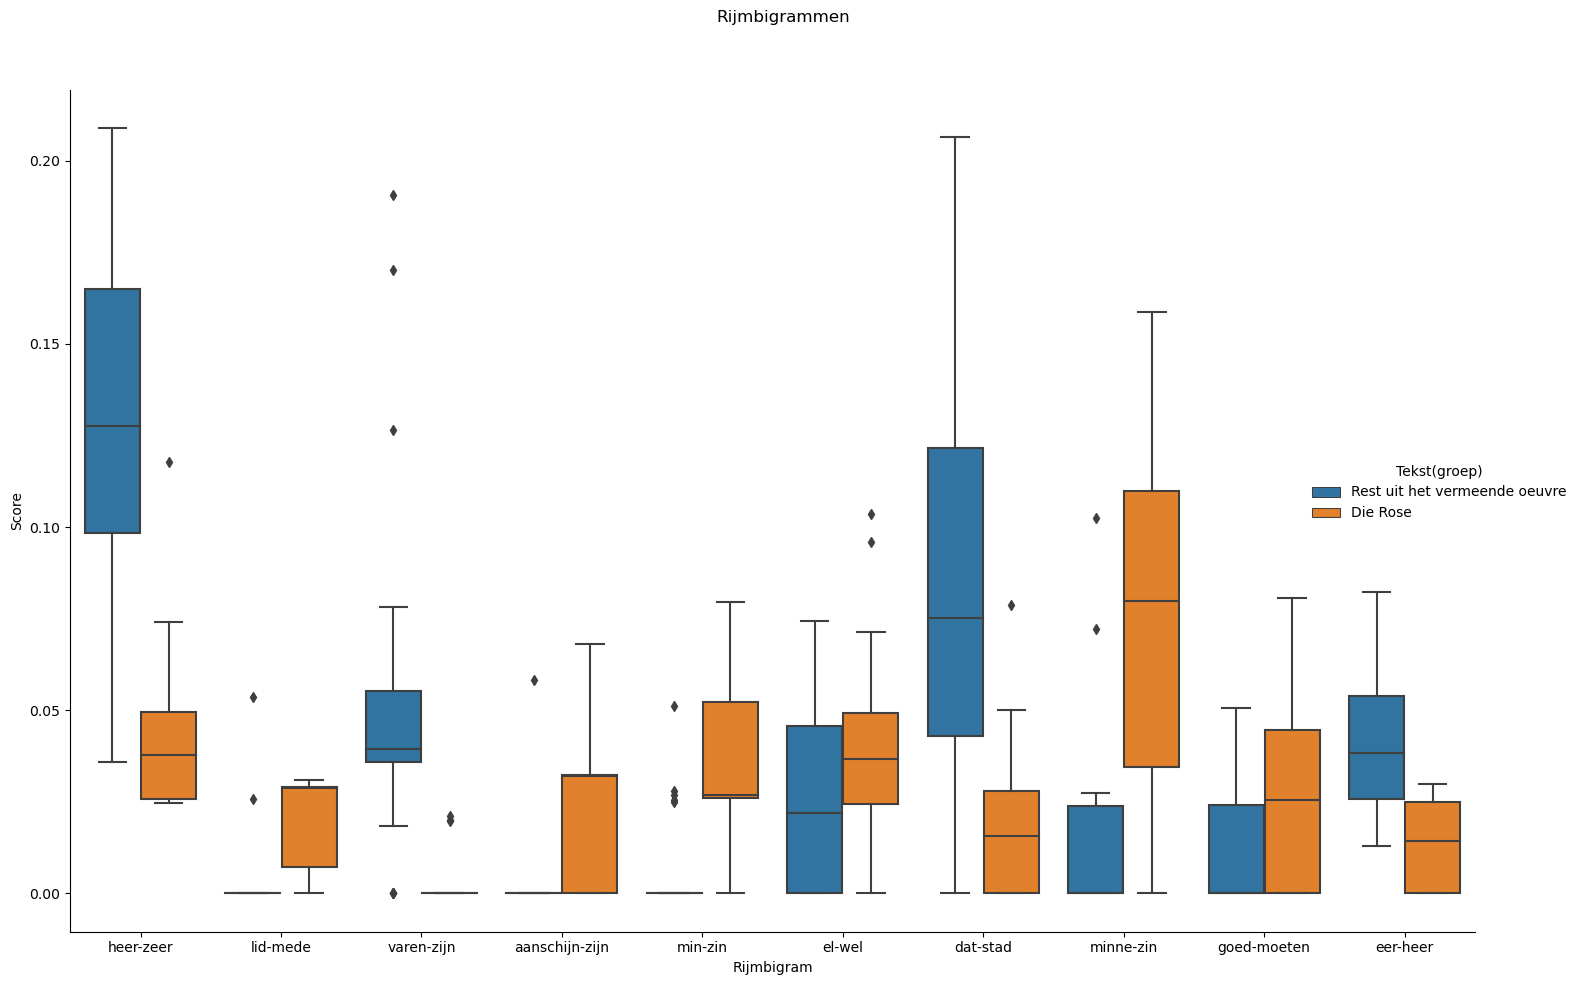

In [28]:
BOW = BOW[forest_importances.index[::-1]]
BOW.index = classes
bow = pd.melt(BOW, value_vars=BOW.columns, ignore_index=False, var_name='Rijmbigram', value_name='Score')
bow = bow.reset_index()
bow['authorship'] = bow['title']
plot = sb.catplot(x="Rijmbigram", hue="authorship", y="Score", data=bow, kind='box', height=10, aspect=1.5);

plot.fig.suptitle('Rijmbigrammen')
legend = plot._legend
legend.set_title('Tekst(groep)')
legend.texts[0].set_text('Rest uit het vermeende oeuvre')
legend.texts[1].set_text('Die Rose')
plt.subplots_adjust(top=0.9)

plt.show()